In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [20]:
samples_regions = {
 '2H10': 'European Neolithic',
 '2H11': 'European Neolithic',
 'atp016': 'European Neolithic',
 'BA64': 'European Neolithic',
 'JP14': 'European Neolithic',
 'NE1': 'European Neolithic',
 'PB675': 'European Neolithic',
 'Stuttgart': 'European Neolithic',
 'BOT2016': 'Steppe',
 'Yamnaya': 'Steppe',
 'KK1': 'Caucasus Hunter-Gatherer',
 'Kolyma1': 'Ancient Siberian',
 'Loschbour': 'European Mesolithic',
 'sf12': 'European Mesolithic',
 'SRA62': 'European Mesolithic',
 'Ust_Ishim': 'Pre-LGM Eurasian',
 'Yana1': 'Pre-LGM Eurasian',
 'WC1': 'Iranian Neolithic',
 'USR1': 'Ancient Berinigian'
}

populations_regions  = {
'CDX' : 'EastAsia',
'CHB' : 'EastAsia',
'CHS' : 'EastAsia',
'JPT' : 'EastAsia',
'KHV' : 'EastAsia',
'CEU' : 'WestEurasia',
'FIN' : 'WestEurasia',
'GBR' : 'WestEurasia',
'IBS' : 'WestEurasia',
'TSI' : 'WestEurasia',
'BEB' : 'SouthAsia',
'GIH' : 'SouthAsia',
'ITU' : 'SouthAsia',
'PJL' : 'SouthAsia',
'STU' : 'SouthAsia',
'Pap' : 'Papuan'
}

In [ ]:
def is_in_segments(s,e,tracts):
    res=[]
    for tract in tracts:
        if max(s, tract[0]) <= min(e, tract[1]):
            if tract[2]!='Melanesia':
                res.append(tract[2])
    return res

def compareTractsToMapPoportion(coverage,dic_map,path_map,min_size,filter):
    df = pd.read_csv(path_map)

    dic_origins = {} # Stores for each sample the number of its archaic segments present in each region

    for index, row in df.iterrows():
        if row['Coverage'] == coverage and int(row['Length']) > min_size and \
            (float(row['similarityImp_Neanderthal'])>filter or float(row['similarityImp_Denisovan'])>filter):
            is_present = is_in_segments(int(row['start']),int(row['end']),dic_map[int(row['Chrom'])])
            sample_name = row['individual']
            if sample_name not in dic_origins:
                dic_origins[sample_name] = {}
            for elt in is_present:
                dic_origins[sample_name][elt] = dic_origins[sample_name].get(elt, 0) + 1



    count_tracts_contemporary_maps = {} # Stores the number of archaic segments found in each contemporary regions
    
    for chrom in dic_map:
        for elt in dic_map[chrom]:
            count_tracts_contemporary_maps[elt[2]] = count_tracts_contemporary_maps.get(elt[2], 0) + 1

    # We normalize the number of archaic segments present in each region and found in the sample by the total of archaic segments present in that region.
    # This is to avoid that samples have more match with a specific region because this region has more data
    for key in dic_origins:
        for elt in dic_origins[key]:
            dic_origins[key][elt] /= count_tracts_contemporary_maps[elt]

    
    for key in dic_origins:
        total = sum(dic_origins[key].values())  # Compute the total number of match for an individual
        if total != 0:
            dic_origins[key] = {elt: dic_origins[key][elt] / total for elt in dic_origins[key]}  # Normalize
            
    return dic_origins

### Read the introgression maps from Archaic Seeker and hmmix

In [ ]:

# Path to the archaic seeker introgression maps which can be downloaded from:
# https://github.com/Shuhua-Group/ArchaicSeeker2.0/tree/master/IntrogressedSeg
# All maps (one for each population) should be put in the directory
directory = 'ArchaicSeekerMaps' 

dicSeeker={}
for i in range(1,23):
    dicSeeker[i]=[]
for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    if os.path.isfile(file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            next(file)
            for line in file:
                sline=line.split('\t')
                if int(sline[3])-int(sline[2]) > 40000 and sline[1]!='X' :
                    dicSeeker[int(sline[1])].append([int(sline[2]),int(sline[3]),filename,sline[6]])

# Path to the hmmix introgression map which can be downloaded from:
# https://doi.org/10.1371/journal.pgen.1007641.s012
f=open('hmmixMap.txt','r')
next(f)
dicSkov={}
for i in range(1,23):
    dicSkov[i]=[]
for line in f:
    sline=line.split('\t')
    if int(sline[4]) > 40000 and sline[1]!='X' and (int(sline[10])>10  or int(sline[11])>10  or int(sline[12])>10): # (Filters recommended in the hmmix paper)
        dicSkov[int(sline[1])].append([int(sline[2]),int(sline[3]),sline[8]])



### Compute segment matches

In [23]:
coverage = '0.0625X'
min_size = 40_000
filter = 0.99
path = '/home/leo/Téléchargements/MergeFragmentsArchaic_SimilarityDistance_AllCoverages_Oct17_Annotated_Shared_cM_SimPrivate_AltaiCha.csv'
data_Seeker = compareTractsToMapPoportion(coverage, dicSeeker,path, min_size,filter)
data_hmmix = compareTractsToMapPoportion(coverage, dicSkov, path, min_size, filter)


In [ ]:
for key in data_Seeker:
    data_Seeker[key].pop('Papuan_mergeLK.seg.txt', None)
    tot = sum(data_Seeker[key].values())
    for key2 in data_Seeker[key]:
        data_Seeker[key][key2] /= tot

sorted_inds = sorted(samples_regions.keys(), key=lambda ind: samples_regions[ind])

df_Seeker = pd.DataFrame(data_Seeker).fillna(0)
df_Seeker = df_Seeker[sorted_inds].transpose()

sorted_ancestry_groups = sorted(df_Seeker.columns, key=lambda pop: populations_regions.get(pop[:3], ""))
df_Seeker = df_Seeker[sorted_ancestry_groups]
df_hmmix = pd.DataFrame(data_hmmix).fillna(0)



### Creates a spreadsheet with the values that compose the heatmap

In [25]:

f_spreadsheet = open("heatmap_archaicseeker_regions_test.csv",'w')
f_spreadsheet.write('Coverage,Sample,KHV,JPT,CDX,CHS,CHB,BEB,GIH,ITU,STU,PJL,CEU,GBR,TSI,IBS,FIN\n')

for ind in df_Seeker.transpose():
    f_spreadsheet.write(f'{coverage},{ind}')
    for value in df_Seeker.transpose()[ind]:
        f_spreadsheet.write(f',{value}')
    f_spreadsheet.write('\n')
f_spreadsheet.close()



f_spreadsheet = open("heatmap_hmmix_regions_test.csv",'w')
f_spreadsheet.write('Coverage,Sample,SouthAsia,WestEurasia,EastAsia,CentralAsiaSiberia\n')
f_spreadsheet = open("heatmap_hmmix_regions.csv",'a')
df_hmmix = df_hmmix[sorted_inds].transpose()
df_hmmix = df_hmmix[['EastAsia','SouthAsia','WestEurasia','CentralAsiaSiberia']]
for ind in df_hmmix.transpose():
    f_spreadsheet.write(f'{coverage},{ind},{a},{b},{c},{d}\n')

f_spreadsheet.close()



### Create the heatmap

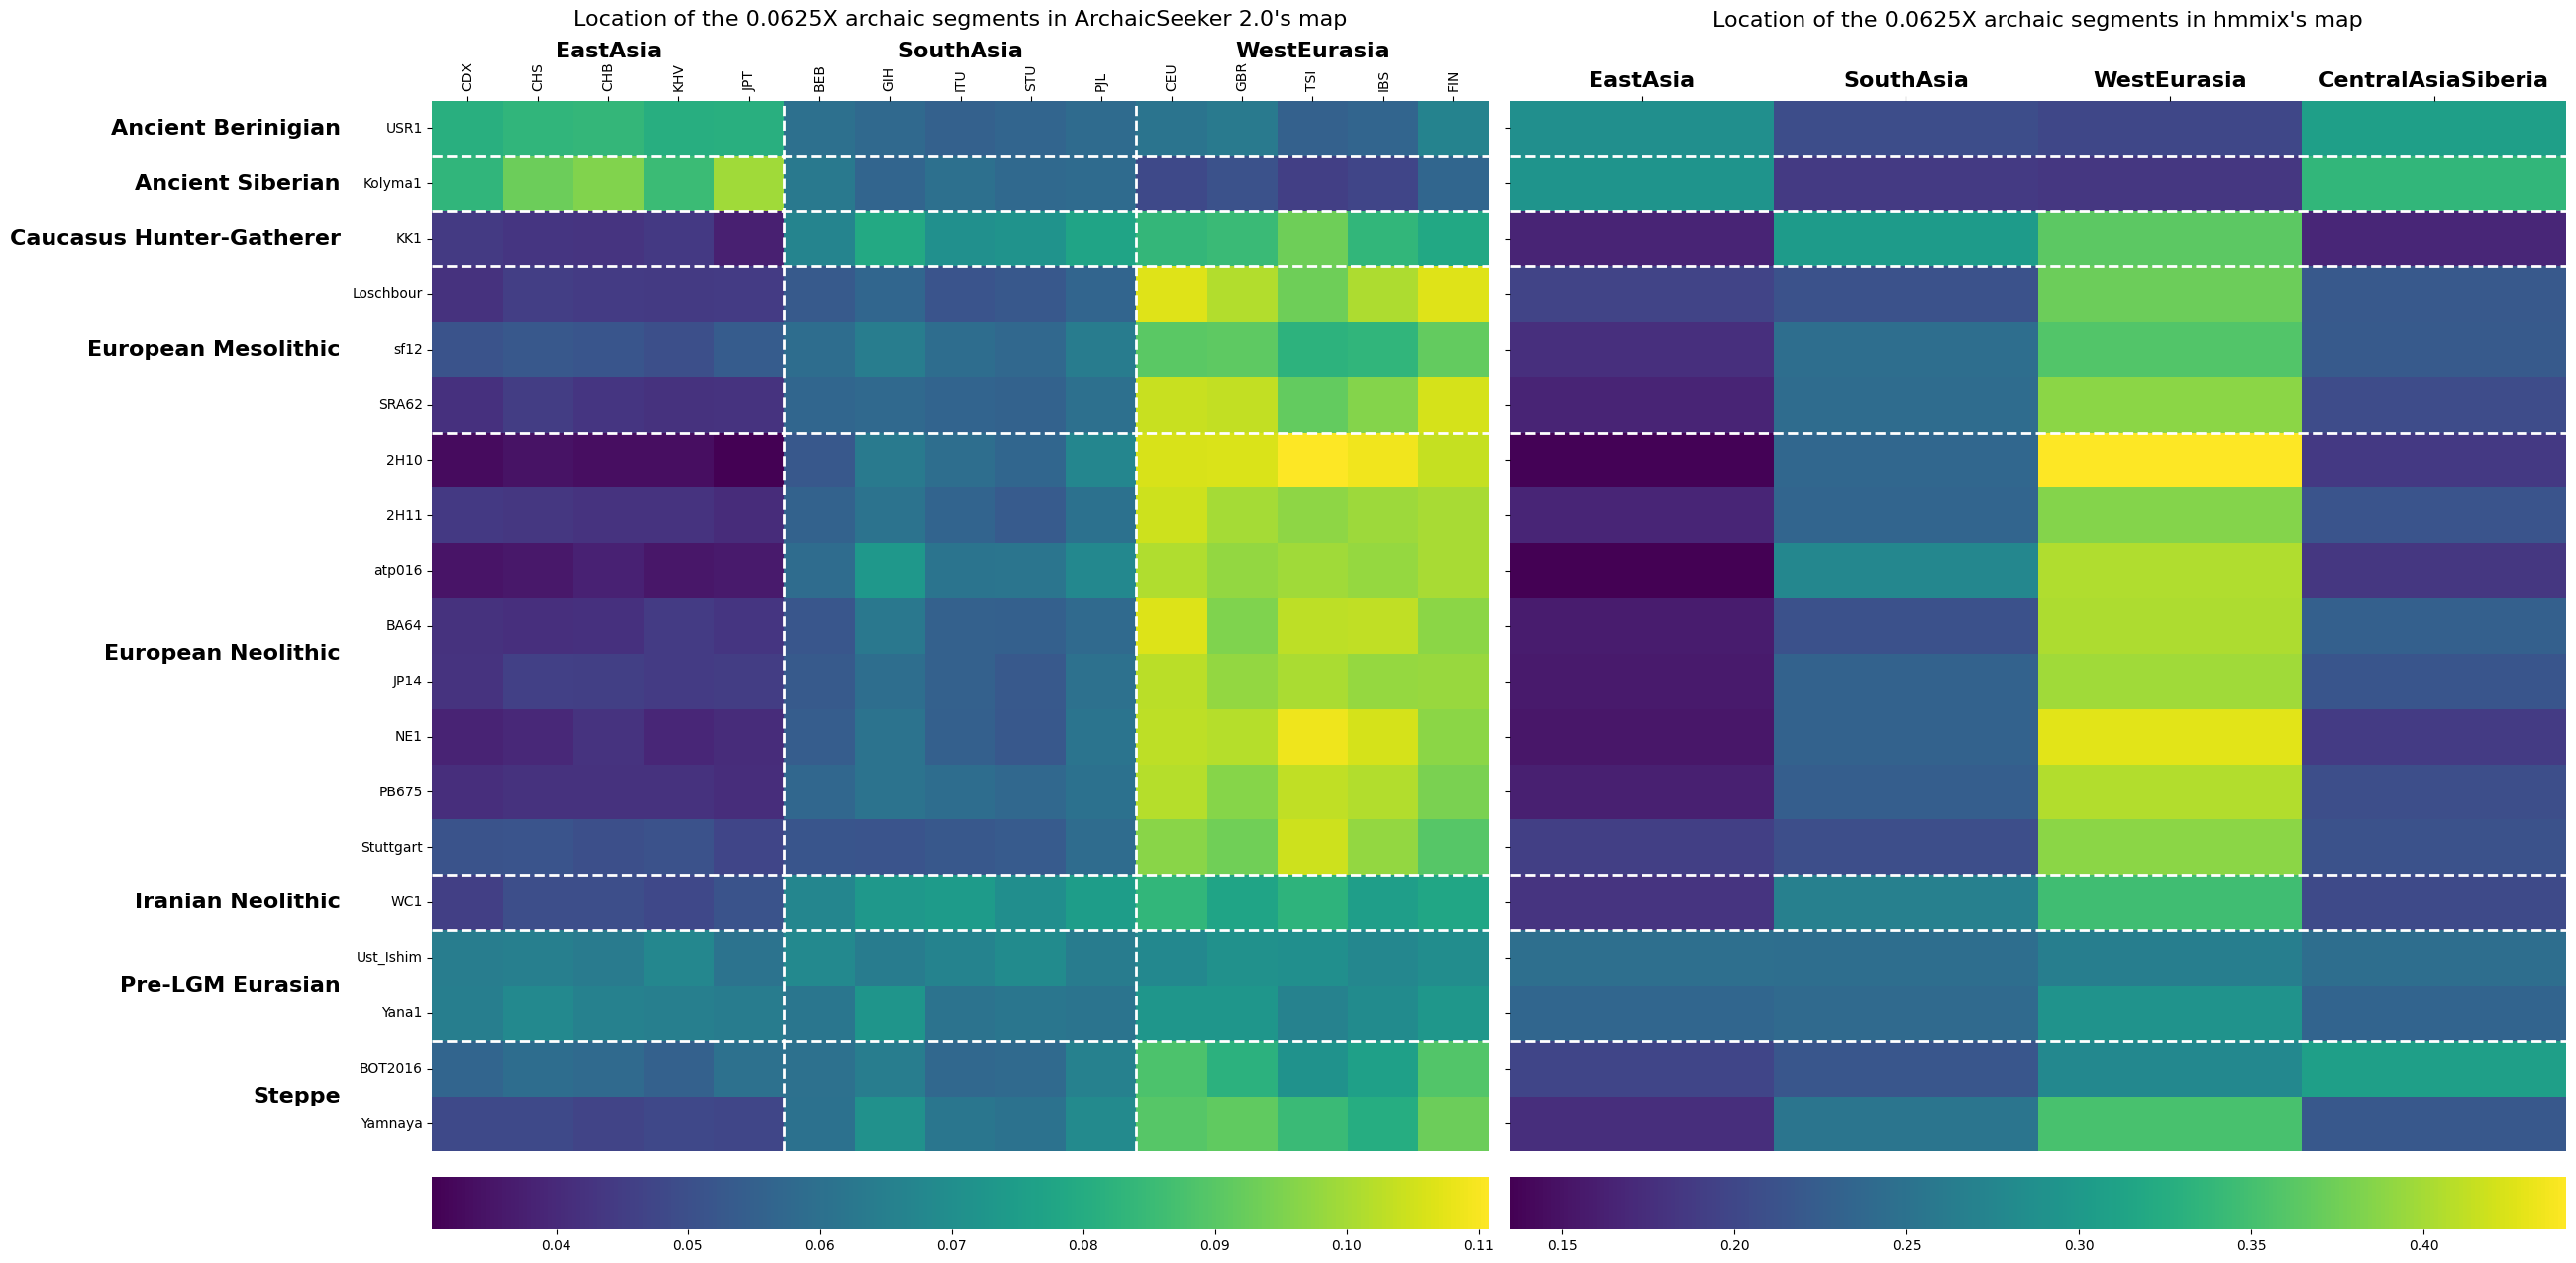

In [ ]:


fig, axes = plt.subplots(1, 2, figsize=(26, 14))  # Create a figure with 2 subplots

# First plot, Seeker

ax = sns.heatmap(df_Seeker, cmap='viridis', annot=False, cbar=True, xticklabels=True, yticklabels=True, ax=axes[0], cbar_kws={'orientation': 'horizontal', 'pad': 0.02})


short_xticklabels = [pop[:3] for pop in sorted_ancestry_groups]
ax.set_xticklabels(short_xticklabels, rotation=90)

unique_locs, loc_positions = [], []
loc_positionsbis = []

for i, ind in enumerate(sorted_inds):
    loc = samples_regions[ind]
    if loc not in unique_locs:
        unique_locs.append(loc)
        loc_positions.append(i)
        loc_positionsbis.append(i)


loc_positionsbis.append(len(sorted_inds))


for pos in loc_positions[1:]:
    ax.axhline(pos, color='white', linestyle='--', linewidth=2)

unique_ancestry_locs, ancestry_positions = [], []
ancestry_positionsbis = []

for i, pop in enumerate(sorted_ancestry_groups):
    loc = populations_regions.get(pop[:3], "Unknown")
    if loc not in unique_ancestry_locs:
        unique_ancestry_locs.append(loc)
        ancestry_positions.append(i)
        ancestry_positionsbis.append(i)
ancestry_positionsbis.append(len(sorted_ancestry_groups))

for pos in ancestry_positions[1:]:
    ax.axvline(pos, color='white', linestyle='--', linewidth=2)

for loc, pos , npos in zip(unique_locs, loc_positions, loc_positionsbis[1:]):
    axes[0].text(-1.3, (pos + npos)/2, loc, va='center', ha='right', fontsize=16, color='black', fontweight='bold')




for loc, pos, npos in zip(unique_ancestry_locs, ancestry_positions,ancestry_positionsbis[1:]):
    axes[0].text((pos+npos)/2, -0.9, loc, va='center', ha='center', fontsize=16, color='black', fontweight='bold', rotation=0)



axes[0].xaxis.set_label_position('top') 
axes[0].xaxis.tick_top()
axes[0].set_title(f"Location of the {coverage} archaic segments in ArchaicSeeker 2.0's map",pad=26,size=16)
axes[0].set_xlabel("")
axes[0].set_ylabel("")

# Second plot, hmmix


for ind in df_hmmix.transpose():
    a =  df_hmmix.transpose()[ind]['SouthAsia']
    b =  df_hmmix.transpose()[ind]['WestEurasia']
    c =  df_hmmix.transpose()[ind]['EastAsia']
    d =  df_hmmix.transpose()[ind]['CentralAsiaSiberia']

ax = sns.heatmap(df_hmmix, cmap='viridis', annot=False, cbar=True, xticklabels=True, yticklabels=True, ax=axes[1], cbar_kws={'orientation': 'horizontal', 'pad': 0.02})

for pos in loc_positions[1:]:
    ax.axhline(pos, color='white', linestyle='--', linewidth=2)


axes[1].xaxis.set_label_position('top') 
axes[1].xaxis.tick_top()

for label in axes[1].get_xticklabels():
    label.set_fontweight('bold')
    label.set_fontsize(16)

axes[1].set_yticklabels([])


axes[1].set_title(f"Location of the {coverage} archaic segments in hmmix's map",pad=54,size=16)
axes[1].set_xlabel("")
axes[1].set_ylabel("")

plt.tight_layout()

plt.savefig(f'{coverage}OriginsBigFont.svg', format='svg')
plt.show()

